# Potato disease classification using Convolutional Neural Network

The dataset is taken from kaggle (https://www.kaggle.com/datasets/arjuntejaswi/plant-village/data)

#### Importing all the necessary libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS=50

In [ ]:
# loading the dataset into tensorflow dataset and this returns a tf.data.dataset object

dataset = tf.keras.utils.image_dataset_from_directory(
                "potato_dataset",
                shuffle = True,
                batch_size = BATCH_SIZE,
                image_size = (IMAGE_SIZE, IMAGE_SIZE)
            )                                          

Found 2152 files belonging to 3 classes.


In [45]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [46]:
len(dataset) # 68 because its  grouped into batches(68*32=2176) approx.  last batch doesnt have 32 files

68

In [47]:
# 1st batch

for batch, labels in dataset.take(1):  
    print(batch.shape)
    print(labels.numpy()) # class names

(32, 256, 256, 3)
[0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 2 1 1 0 1 1 1 1 0 0 1 1 0 1]


### 32- batch size
### 256- image size
### 0, 1, 2-class names

In [48]:
# first_image

for batch, labels in dataset.take(1):
    print(batch[0].numpy()) 

[[[132. 130. 141.]
  [128. 126. 137.]
  [143. 141. 152.]
  ...
  [171. 174. 183.]
  [171. 174. 183.]
  [171. 174. 183.]]

 [[162. 160. 171.]
  [144. 142. 153.]
  [152. 150. 161.]
  ...
  [173. 176. 185.]
  [173. 176. 185.]
  [173. 176. 185.]]

 [[130. 128. 139.]
  [142. 140. 151.]
  [133. 131. 142.]
  ...
  [174. 177. 186.]
  [175. 178. 187.]
  [176. 179. 188.]]

 ...

 [[140. 138. 151.]
  [149. 147. 160.]
  [138. 136. 149.]
  ...
  [151. 153. 165.]
  [154. 156. 168.]
  [158. 160. 172.]]

 [[127. 125. 138.]
  [128. 126. 139.]
  [122. 120. 133.]
  ...
  [157. 159. 171.]
  [158. 160. 172.]
  [159. 161. 173.]]

 [[133. 131. 144.]
  [123. 121. 134.]
  [117. 115. 128.]
  ...
  [159. 161. 173.]
  [158. 160. 172.]
  [156. 158. 170.]]]


In [49]:
for batch, labels in dataset.take(1):
    print(batch[0].shape)  

(256, 256, 3)


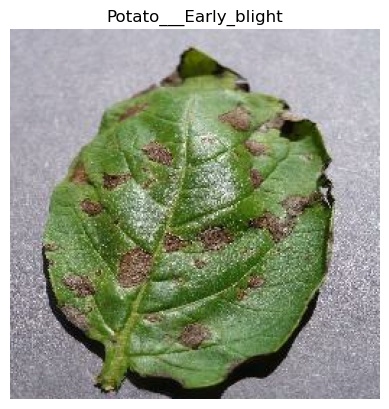

In [50]:
# 1st image

for batch, labels in dataset.take(1):
    plt.imshow(batch[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")

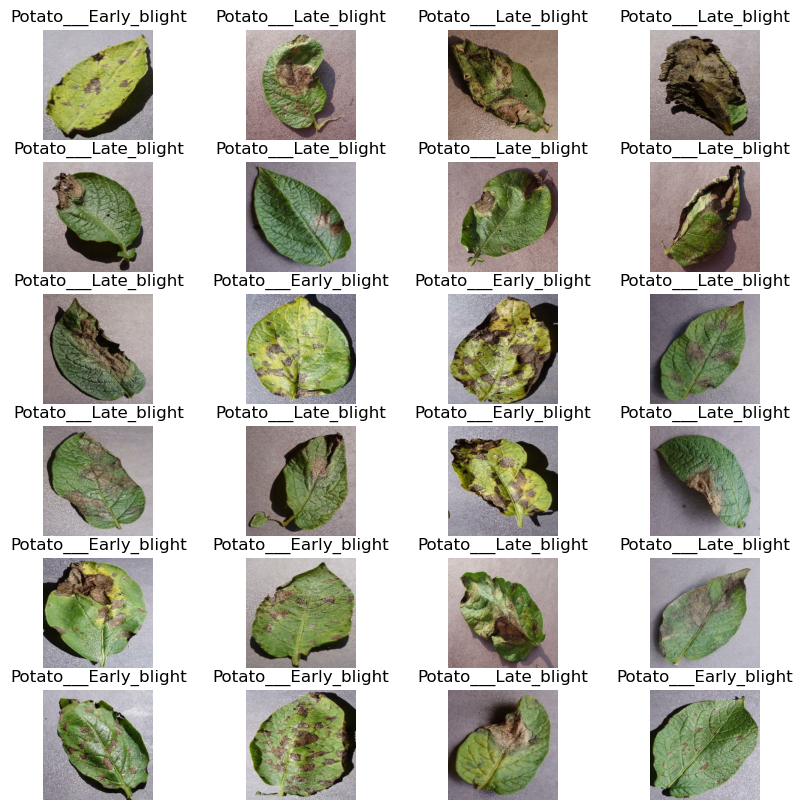

In [51]:
plt.figure(figsize=(10, 10))
for batch, labels in dataset.take(1):
    for i in range(24):
        ax = plt.subplot(6, 4, i+1)
        plt.imshow(batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [52]:
len(dataset)

68

In [53]:
# 80% of the entire dataset

int(len(dataset)*0.8)

54

In [54]:
# splitting the dataset for training

train_ds = dataset.take(54)

In [55]:
# creating "remaining_ds" which includes validation and testing dataset

remaining_ds = dataset.skip(54) 

In [56]:
print(len(train_ds))
print(len(remaining_ds))

54
14


In [57]:
val_size = 0.1 #train-80%, validation-10%, test-10%

In [58]:
len(dataset)*0.1

6.800000000000001

Splitting validation (val_ds) and test (test_ds) data from "remaining_ds"

In [59]:
val_ds = remaining_ds.take(8)
len(val_ds)

8

In [60]:
test_ds = remaining_ds.skip(8)
len(test_ds)

6

The following function takes the Tensorflow dataset and the split ratio and returns the training, validation and test sets.

In [61]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [62]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

Confirming the training, validation and test size.

In [63]:
len(train_ds)

54

In [64]:
len(val_ds)

6

In [65]:
len(test_ds)

8

In [66]:
#cache improves the performance of the pipeline

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [67]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [68]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [69]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
])
model.build(input_shape=input_shape)

In [70]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [71]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [72]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 44s 786ms/step - loss: 0.9183 - accuracy: 0.4902 - val_loss: 0.9042 - val_accuracy: 0.6250
Epoch 2/50
54/54 [==============================] - 44s 806ms/step - loss: 0.8033 - accuracy: 0.6146 - val_loss: 0.7694 - val_accuracy: 0.6094
Epoch 3/50
54/54 [==============================] - 46s 857ms/step - loss: 0.5035 - accuracy: 0.7876 - val_loss: 0.3187 - val_accuracy: 0.8646
Epoch 4/50
54/54 [==============================] - 46s 848ms/step - loss: 0.2947 - accuracy: 0.8906 - val_loss: 0.3697 - val_accuracy: 0.8438
Epoch 5/50
54/54 [==============================] - 42s 783ms/step - loss: 0.2330 - accuracy: 0.9068 - val_loss: 0.1454 - val_accuracy: 0.9323
Epoch 6/50
54/54 [==============================] - 44s 820ms/step - loss: 0.1418 - accuracy: 0.9433 - val_loss: 0.1600 - val_accuracy: 0.9271
Epoch 7/50
54/54 [==============================] - 47s 863ms/step - loss: 0.3031 - accuracy: 0.8843 - val_loss: 0.2645 - val_accuracy: 0.8906

In [73]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 172ms/step - loss: 0.0035 - accuracy: 1.0000


In [74]:
scores

[0.0034634398762136698, 1.0]

In [75]:
history

In [76]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [77]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [78]:
len(history.history["accuracy"])

50

In [79]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

Text(0.5, 1.0, 'Training and Validation Accuracy')

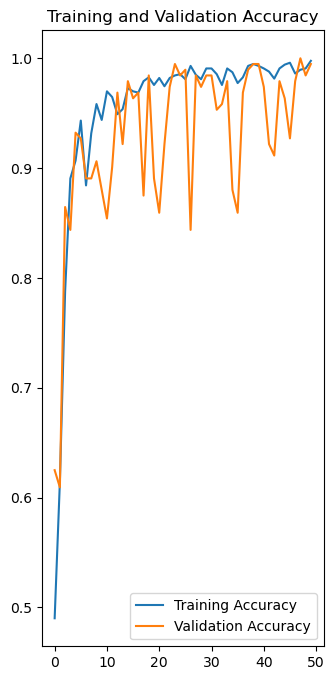

In [80]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


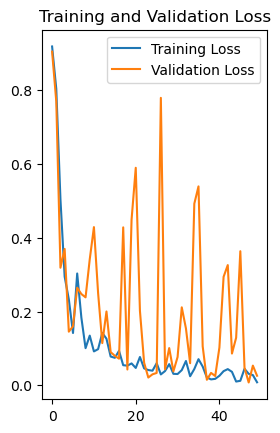

In [81]:
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
first images's actual label :  Potato___healthy
1/1 [==============================] - 0s 276ms/step
[9.2769062e-07 6.4333943e-03 9.9356562e-01]
2
predicted : Potato___healthy


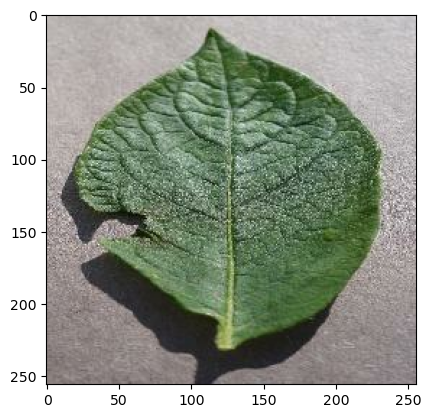

In [94]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first images's actual label : " , class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0]) #result is of three probalilities for 3 classes
    print(np.argmax(batch_prediction[0])) #predicts class_name 0th location
    print("predicted :", class_names[np.argmax(batch_prediction[0])])

In [96]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


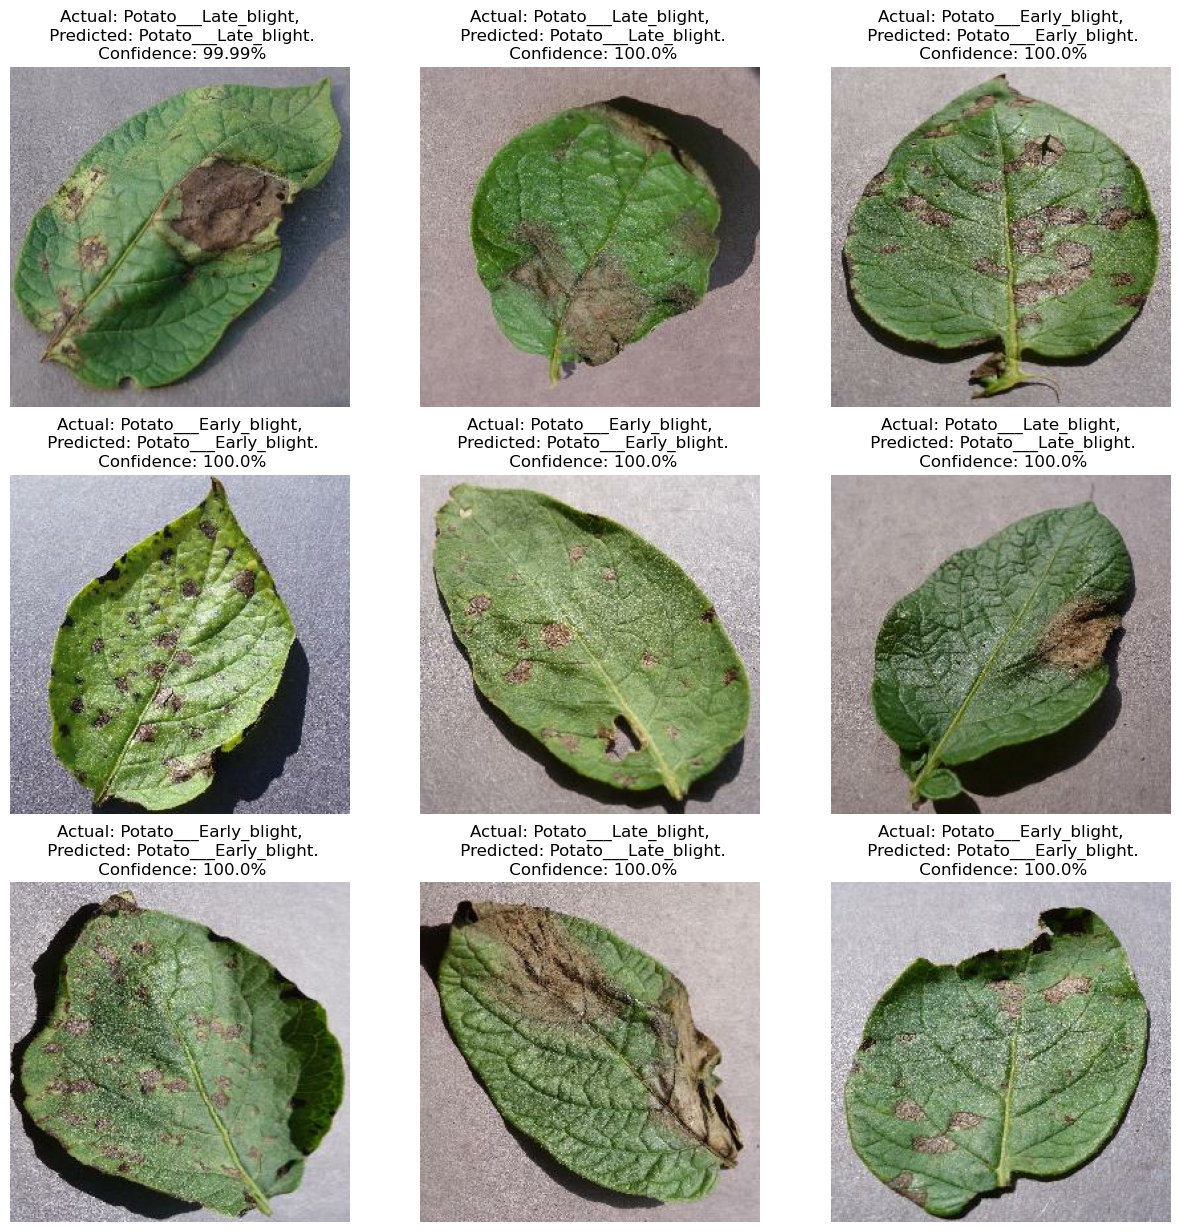

In [97]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")